# Loading Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

In [ ]:

import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

# all-images file should be uploaded to the same file
imageNames = glob.glob("/content/drive/MyDrive/project/all-images/*.json")

dataset = []
labels = []

for i, imName in enumerate(imageNames):

    # Opening JSON file
    f = open(imName)
    data = json.load(f)
    for j in range(len(data['annotations'])):

        if 'COVID-19' in (data['annotations'][j]['name']):
          #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            print(label)
            break

        if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
            or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
            or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
            #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            break

#Convert data shape of (n_of_samples, width, height, 1)
dataset = np.dstack(dataset)    
dataset = np.rollaxis(dataset,-1)
labels = np.array(labels)

#convert images gray scale to rgb
data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))

# save data and labels into a folder
np.save("/content/drive/MyDrive/project/data.npy", data)
np.save("/content/drive/MyDrive/project/labels.npy", labels)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once you save your data, you can load it from your directory.

In [2]:
#load data
import numpy as np

data = np.load('/content/drive/MyDrive/Data deep learning assignment/data.npy')
labels = np.load('/content/drive/MyDrive/Data deep learning assignment/labels.npy')

In [3]:
print(data.shape)
print(labels.shape)

(6392, 156, 156, 3)
(6392,)


In [4]:
# check label distribution. We only have 127 COVID-19 cases, but in the assignment he said there should be 517? 
# some other people have that problem too, we should ask the teacher about this.
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{'Bacterial Pneumonia': 2816,
 'COVID-19': 127,
 'No Pneumonia (healthy)': 1606,
 'Viral Pneumonia': 1843}

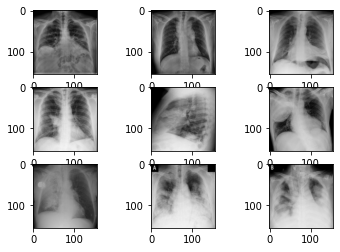

In [5]:
# plot first few images

from matplotlib import pyplot as plt
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(data[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Preprocessing Steps



In [3]:
from tensorflow.keras.utils import to_categorical

# one-hot encode labels
labels = np.array(np.unique(labels, return_inverse=True)[1].tolist())
labels = to_categorical(labels) 
"""
Bacterial Pneumonia = 2
COVID-19 = 1
No Pneumonia (healthy) = 3
Viral Pneumonia = 0
"""

'\nBacterial Pneumonia = 2\nCOVID-19 = 1\nNo Pneumonia (healthy) = 3\nViral Pneumonia = 0\n'

In [7]:
labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

## Splitting Data

In [4]:
 from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4090, 156, 156, 3)
(1023, 156, 156, 3)
(1279, 156, 156, 3)
(4090, 4)
(1023, 4)
(1279, 4)


## Normalize Data

In [5]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [11]:
print(X_train.shape[1:])

(156, 156, 3)


# Create Baseline Model

In [12]:
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu', input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu', input_shape = X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu', input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), padding="same", activation='relu', input_shape = X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                    

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# save checkpoint: during training, save the weights of the epoch with the highest validation-accuracy
filepath_baseline = '/content/drive/MyDrive/project/best_model_baseline.hdf5'
checkpoint = ModelCheckpoint(filepath_baseline, monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/10
128/128 [==============================] - ETA: 0s - loss: 0.9719 - accuracy: 0.5516
Epoch 1: val_accuracy improved from -inf to 0.62757, saving model to /content/drive/MyDrive/project/best_model_baseline.hdf5
128/128 [==============================] - 26s 95ms/step - loss: 0.9719 - accuracy: 0.5516 - val_loss: 0.8016 - val_accuracy: 0.6276
Epoch 2/10
127/128 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.7197
Epoch 2: val_accuracy improved from 0.62757 to 0.74682, saving model to /content/drive/MyDrive/project/best_model_baseline.hdf5
128/128 [==============================] - 8s 61ms/step - loss: 0.6622 - accuracy: 0.7196 - val_loss: 0.6394 - val_accuracy: 0.7468
Epoch 3/10
127/128 [============================>.] - ETA: 0s - loss: 0.5810 - accuracy: 0.7589
Epoch 3: val_accuracy improved from 0.74682 to 0.76540, saving model to /content/drive/MyDrive/project/best_model_baseline.hdf5
128/128 [==============================] - 8s 62ms/step - loss: 0.

# Analyze the performance of the baseline model

## 1. Metrics

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, f1_score, precision_recall_fscore_support
import pandas as pd
from keras import layers, models

################ validation metrics
model = models.load_model(filepath_baseline)

#val_report = classification_report(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1), output_dict=True)

# accuracy
val_accuracy = accuracy_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))

# f1
val_f1 = pd.DataFrame(f1_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1), average=None)[None],columns=['Viral Pneumonia','COVID-19','Bacterial Pneumonia', 'No Pneumonia (healthy)'])

# sensitivity and specificity
res = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(
      y_val.argmax(axis=1)==l,model.predict(X_val).argmax(axis=1)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

val_sens_spec = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
val_sens_spec["class"].replace({0: "Viral Pneumonia", 1: "COVID-19", 2:"Bacterial Pneumonia", 3:"No Pneumonia (healthy)"}, inplace=True)

################ test metrics
# accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

# f1
test_f1 = pd.DataFrame(f1_score(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), average=None)[None],columns=['Viral Pneumonia','COVID-19','Bacterial Pneumonia', 'No Pneumonia (healthy)'])

# sensitivity and specificity
res = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(
      y_test.argmax(axis=1)==l,model.predict(X_test).argmax(axis=1)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

test_sens_spec = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
test_sens_spec["class"].replace({0: "Viral Pneumonia", 1: "COVID-19", 2:"Bacterial Pneumonia", 3:"No Pneumonia (healthy)"}, inplace=True)

40/40 [==============================] - 1s 14ms/step


In [16]:
print('Validation accuracy: %.3f' % (val_accuracy))
print()
print('Validation F1-score per class:')
print(val_f1)
print()
print('Validation Sensitivity and Specificity per class:')
print(val_sens_spec)
print()
print()
print('Test accuracy: %.3f' % (test_accuracy))
print()
print('Test F1-score per class:')
print(test_f1)
print()
print('Test Sensitivity and Specificity per class:')
print(test_sens_spec)

Validation accuracy: 0.781

Validation F1-score per class:
   Viral Pneumonia  COVID-19  Bacterial Pneumonia  No Pneumonia (healthy)
0         0.802632  0.095238             0.906561                0.668852

Validation Sensitivity and Specificity per class:
                    class  sensitivity  specificity
0         Viral Pneumonia     0.833916     0.811530
1                COVID-19     1.000000     0.050000
2     Bacterial Pneumonia     0.976501     0.887160
3  No Pneumonia (healthy)     0.847527     0.691525


Test accuracy: 0.776

Test F1-score per class:
   Viral Pneumonia  COVID-19  Bacterial Pneumonia  No Pneumonia (healthy)
0         0.811052  0.066667             0.875389                0.667539

Test Sensitivity and Specificity per class:
                    class  sensitivity  specificity
0         Viral Pneumonia     0.855944     0.806738
1                COVID-19     0.996810     0.040000
2     Bacterial Pneumonia     0.958246     0.875389
3  No Pneumonia (healthy)     0.

## 2. Graphs

### Training and Validation Loss/Accuracy

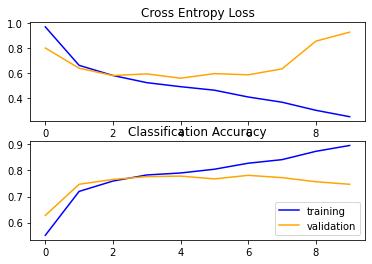

In [17]:
from matplotlib import pyplot as plt
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
 
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

### Validation Confusion Matrix

32/32 [==============================] - 1s 16ms/step


<AxesSubplot:>

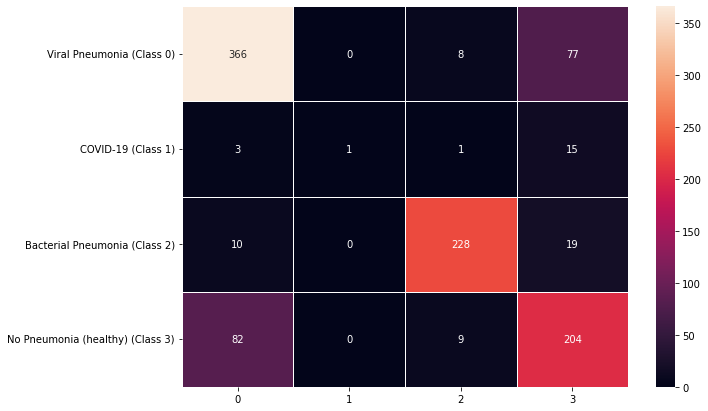

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_matrix = confusion_matrix(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))

labels = ['Viral Pneumonia (Class 0)','COVID-19 (Class 1)','Bacterial Pneumonia (Class 2)', 'No Pneumonia (healthy) (Class 3)']
cols = [0,1,2,3]
val_matrix = pd.DataFrame(val_matrix, index = labels,
                  columns = cols)

fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(val_matrix, annot=True,fmt='.0f', linewidths=.5, ax=ax)

### Test Confusion Matrix

40/40 [==============================] - 1s 17ms/step


<AxesSubplot:>

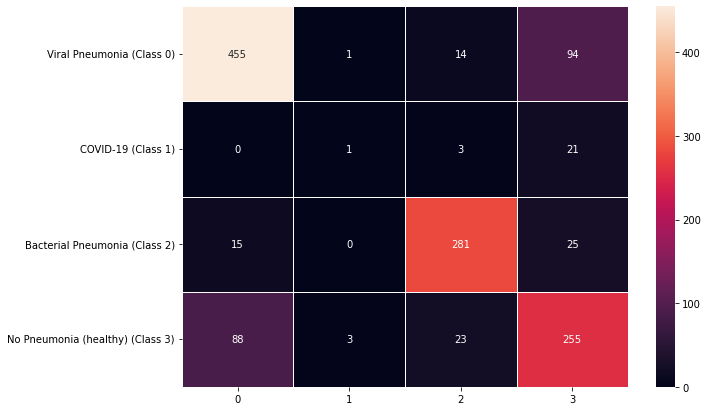

In [19]:
test_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

labels = ['Viral Pneumonia (Class 0)','COVID-19 (Class 1)','Bacterial Pneumonia (Class 2)', 'No Pneumonia (healthy) (Class 3)']
cols = [0,1,2,3]
test_matrix = pd.DataFrame(test_matrix, index = labels,
                  columns = cols)

fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(test_matrix, annot=True,fmt='.0f', linewidths=.5, ax=ax)

### Validation ROC

32/32 [==============================] - 1s 16ms/step
Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.92


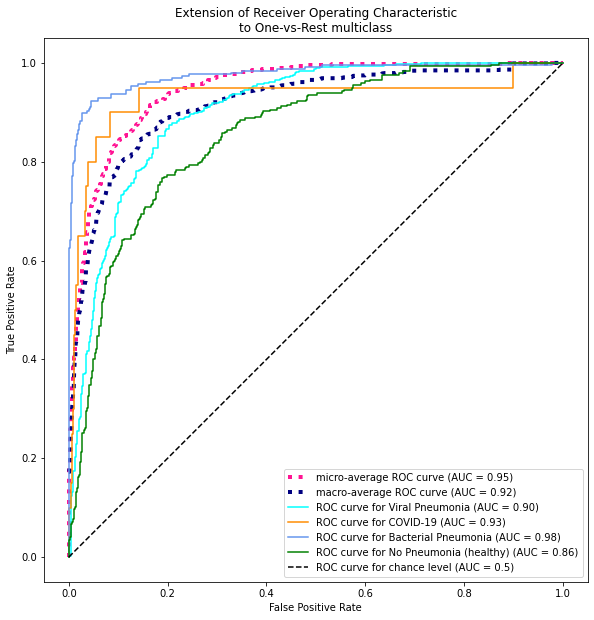

In [20]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

y_pred_val = model.predict(X_val)
n_classes = 4
target_names = ['Viral Pneumonia', 'COVID-19', 'Bacterial Pneumonia', 'No Pneumonia (healthy)']

################## micro
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

################## macro
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

################# ROC curves
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_val[:, class_id],
        y_pred_val[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

### Test ROC

40/40 [==============================] - 1s 16ms/step
Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.93


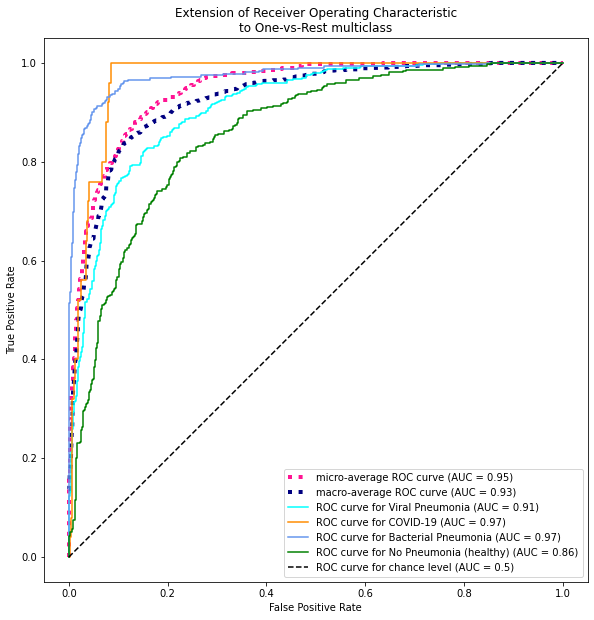

In [21]:
y_pred = model.predict(X_test)
n_classes = 4
target_names = ['Viral Pneumonia', 'COVID-19', 'Bacterial Pneumonia', 'No Pneumonia (healthy)']

################## micro
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

################## macro
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

################# ROC curves
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

# Adapting/fine-tuning the network

## 1. Model without Data Augmentation

In [23]:
# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf
#from kerastuner import HyperModel
#from kerastuner.tuners import RandomSearch
#from kerastuner.tuners import Hyperband

from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import numpy as np

data = np.load('/content/drive/MyDrive/Data deep learning assignment/data.npy')
labels = np.load('/content/drive/MyDrive/Data deep learning assignment/labels.npy')

labels = np.array(np.unique(labels, return_inverse=True)[1].tolist())
labels = to_categorical(labels) 

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [24]:
from tensorflow.keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint


model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape = X_train.shape[1:], kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Conv2D(128, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Conv2D(256, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# early stopping is applied: stop training when the validation-accuracy stops improving after 6 epochs
earlystop = EarlyStopping(monitor='val_accuracy', patience=6, start_from_epoch=20)

# save checkpoint: during training, save the weights of the epoch with the highest validation-accuracy
filepath_no_augmentation = '/content/drive/MyDrive/project/best_model_no_augmentation.hdf5'
checkpoint = ModelCheckpoint(filepath_no_augmentation, monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[earlystop, checkpoint])

Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 1.2154 - accuracy: 0.4741
Epoch 1: val_accuracy improved from -inf to 0.69013, saving model to /content/drive/MyDrive/project/best_model_no_augmentation.hdf5
128/128 [==============================] - 14s 57ms/step - loss: 1.2154 - accuracy: 0.4741 - val_loss: 0.8946 - val_accuracy: 0.6901
Epoch 2/50
127/128 [============================>.] - ETA: 0s - loss: 0.8649 - accuracy: 0.6626
Epoch 2: val_accuracy improved from 0.69013 to 0.74389, saving model to /content/drive/MyDrive/project/best_model_no_augmentation.hdf5
128/128 [==============================] - 6s 45ms/step - loss: 0.8638 - accuracy: 0.6633 - val_loss: 0.6892 - val_accuracy: 0.7439
Epoch 3/50
127/128 [============================>.] - ETA: 0s - loss: 0.7576 - accuracy: 0.7131
Epoch 3: val_accuracy improved from 0.74389 to 0.77517, saving model to /content/drive/MyDrive/project/best_model_no_augmentation.hdf5
128/128 [==============================] - 6s

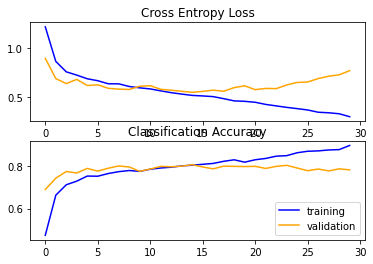

In [25]:
#from matplotlib import pyplot as plt
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
 
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

# load in saved model with highest validation-accuracy during training
model = models.load_model(filepath_no_augmentation)

# create predictions on test set
y_pred = model.predict(X_test)

# evaluate validation and test score
val_loss, val_acc = model.evaluate(X_val, y_val)
test_loss, test_acc = model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 15ms/step - loss: 0.5386 - accuracy: 0.8139


## 2. Model with Data Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

data = np.load('/content/drive/MyDrive/project/data.npy')
labels = np.load('/content/drive/MyDrive/project/labels .npy')

labels = np.array(np.unique(labels, return_inverse=True)[1].tolist())
labels = to_categorical(labels) 

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# define data augmentation steps
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.1,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=True,
    vertical_flip=True,
    #shear_range=0.2
    )

# apply data augmentation to training set
datagen.fit(X_train)

# generate augmented training set
train_generator = datagen.flow(X_train, y_train)

In [4]:
from tensorflow.keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape = X_train.shape[1:], kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Conv2D(128, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Conv2D(256, (3,3), padding="same", activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(4, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

earlystop = EarlyStopping(monitor='val_accuracy', patience=10, start_from_epoch=30)
filepath_augmentation = '/content/drive/MyDrive/project/best_model_augmentation.hdf5'
checkpoint = ModelCheckpoint(filepath_augmentation, monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')

history = model.fit(train_generator, validation_data=(X_val,y_val), epochs=100, batch_size=32, callbacks=[earlystop, checkpoint])

Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 1.2745 - accuracy: 0.3988
Epoch 1: val_accuracy improved from -inf to 0.48485, saving model to /content/drive/MyDrive/project/best_model_augmentation.hdf5
128/128 [==============================] - 42s 215ms/step - loss: 1.2745 - accuracy: 0.3988 - val_loss: 1.1053 - val_accuracy: 0.4848
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 1.0399 - accuracy: 0.5582
Epoch 2: val_accuracy improved from 0.48485 to 0.65787, saving model to /content/drive/MyDrive/project/best_model_augmentation.hdf5
128/128 [==============================] - 26s 204ms/step - loss: 1.0399 - accuracy: 0.5582 - val_loss: 0.8666 - val_accuracy: 0.6579
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.9175 - accuracy: 0.6149
Epoch 3: val_accuracy improved from 0.65787 to 0.69013, saving model to /content/drive/MyDrive/project/best_model_augmentation.hdf5
128/128 [==============================] - 26s 2

In [ ]:
# best: fc:64,64     L2=0.0001      Lr=0.0001
# train lower than validation : https://www.quora.com/Can-validation-accuracy-be-higher-than-training-accuracy

# Analyze the performance of the tuned model

## 1. Metrics

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, f1_score, precision_recall_fscore_support
import pandas as pd
from keras import layers, models

################ validation metrics
model = models.load_model(filepath_augmentation)

# accuracy
val_accuracy = accuracy_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))

# f1
val_f1 = pd.DataFrame(f1_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1), average=None)[None],columns=['Viral Pneumonia','COVID-19','Bacterial Pneumonia', 'No Pneumonia (healthy)'])

# sensitivity and specificity
res = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(
      y_val.argmax(axis=1)==l,model.predict(X_val).argmax(axis=1)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

val_sens_spec = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
val_sens_spec["class"].replace({0: "Viral Pneumonia", 1: "COVID-19", 2:"Bacterial Pneumonia", 3:"No Pneumonia (healthy)"}, inplace=True)

################ test metrics
# accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

# f1
test_f1 = pd.DataFrame(f1_score(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), average=None)[None],columns=['Viral Pneumonia','COVID-19','Bacterial Pneumonia', 'No Pneumonia (healthy)'])

# sensitivity and specificity
res = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(
      y_test.argmax(axis=1)==l,model.predict(X_test).argmax(axis=1)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

test_sens_spec = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
test_sens_spec["class"].replace({0: "Viral Pneumonia", 1: "COVID-19", 2:"Bacterial Pneumonia", 3:"No Pneumonia (healthy)"}, inplace=True)

32/32 [==============================] - 0s 14ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 1s 17ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 1s 16ms/step


In [10]:
print('Validation accuracy: %.3f' % (val_accuracy))
print()
print('Validation F1-score per class:')
print(val_f1)
print()
print('Validation Sensitivity and Specificity per class:')
print(val_sens_spec)
print()
print()
print('Test accuracy: %.3f' % (test_accuracy))
print()
print('Test F1-score per class:')
print(test_f1)
print()
print('Test Sensitivity and Specificity per class:')
print(test_sens_spec)

Validation accuracy: 0.815

Validation F1-score per class:
   Viral Pneumonia  COVID-19  Bacterial Pneumonia  No Pneumonia (healthy)
0         0.845494       0.0             0.929961                0.693103

Validation Sensitivity and Specificity per class:
                    class  sensitivity  specificity
0         Viral Pneumonia     0.847902     0.873614
1                COVID-19     1.000000     0.000000
2     Bacterial Pneumonia     0.976501     0.929961
3  No Pneumonia (healthy)     0.884615     0.681356


Test accuracy: 0.819

Test F1-score per class:
   Viral Pneumonia  COVID-19  Bacterial Pneumonia  No Pneumonia (healthy)
0         0.842382       0.0             0.928125                0.716378

Test Sensitivity and Specificity per class:
                    class  sensitivity  specificity
0         Viral Pneumonia     0.864336     0.852837
1                COVID-19     1.000000     0.000000
2     Bacterial Pneumonia     0.977035     0.925234
3  No Pneumonia (healthy)     0.

## 2. Graphs

### Training and Validation Loss/Accuracy

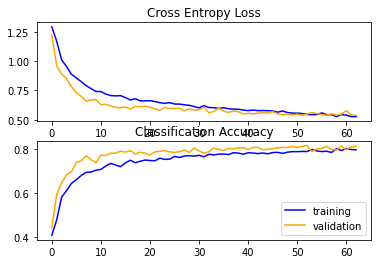

In [11]:
from matplotlib import pyplot as plt
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
 
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

### Validation Confusion Matrix

32/32 [==============================] - 1s 17ms/step


<AxesSubplot:>

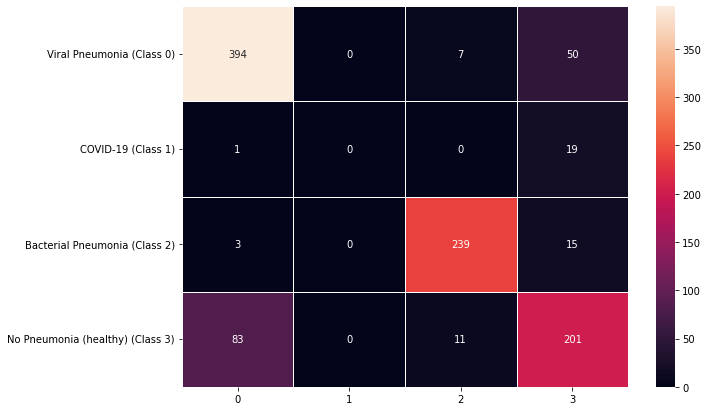

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_matrix = confusion_matrix(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))

labels = ['Viral Pneumonia (Class 0)','COVID-19 (Class 1)','Bacterial Pneumonia (Class 2)', 'No Pneumonia (healthy) (Class 3)']
cols = [0,1,2,3]
val_matrix = pd.DataFrame(val_matrix, index = labels,
                  columns = cols)

fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(val_matrix, annot=True,fmt='.0f', linewidths=.5, ax=ax)

### Test Confusion Matrix

40/40 [==============================] - 1s 16ms/step


<AxesSubplot:>

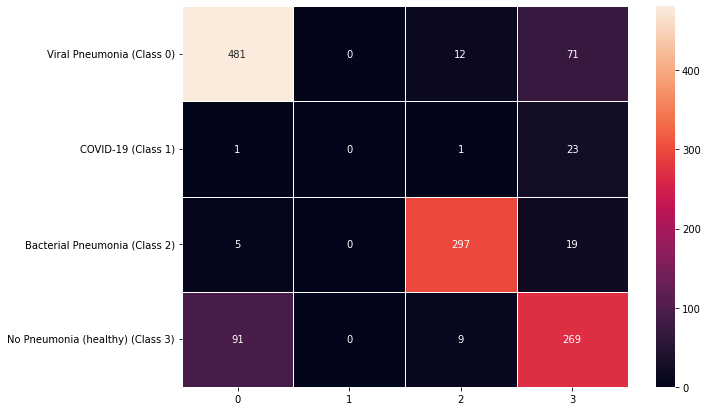

In [13]:
test_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

labels = ['Viral Pneumonia (Class 0)','COVID-19 (Class 1)','Bacterial Pneumonia (Class 2)', 'No Pneumonia (healthy) (Class 3)']
cols = [0,1,2,3]
test_matrix = pd.DataFrame(test_matrix, index = labels,
                  columns = cols)

fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(test_matrix, annot=True,fmt='.0f', linewidths=.5, ax=ax)

### Validation ROC

32/32 [==============================] - 0s 15ms/step
Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.93


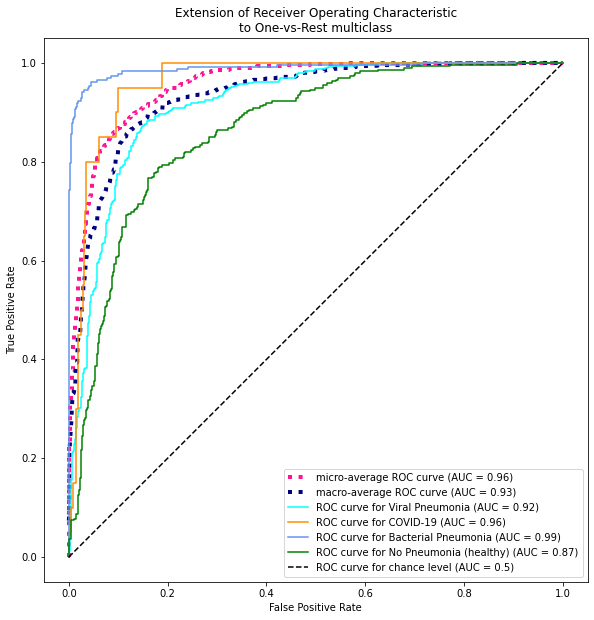

In [14]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

y_pred_val = model.predict(X_val)
n_classes = 4
target_names = ['Viral Pneumonia', 'COVID-19', 'Bacterial Pneumonia', 'No Pneumonia (healthy)']

################## micro
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

################## macro
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

################# ROC curves
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_val[:, class_id],
        y_pred_val[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

### Test ROC

40/40 [==============================] - 1s 14ms/step
Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.94


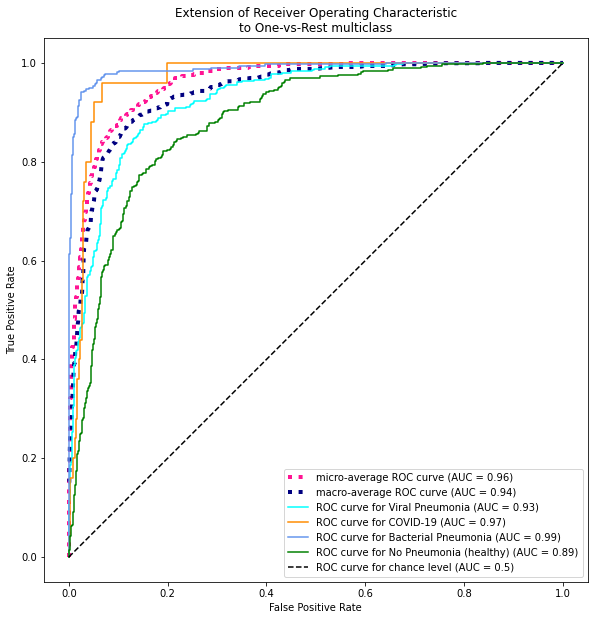

In [15]:
y_pred = model.predict(X_test)
n_classes = 4
target_names = ['Viral Pneumonia', 'COVID-19', 'Bacterial Pneumonia', 'No Pneumonia (healthy)']

################## micro
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

################## macro
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

################# ROC curves
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

# Transfer Learning

In [10]:
# Updated code with L2 regularization and Early Stopping
# Imports
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
from keras.callbacks import ModelCheckpoint
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential

# load data
data = np.load('/content/drive/MyDrive/Data deep learning assignment/data.npy')
labels = np.load('/content/drive/MyDrive/Data deep learning assignment/labels.npy')
filepath_augmentation = '/content/drive/MyDrive/project/best_model_augmentation.hdf5'

# one-hot encode labels
labels = np.array(np.unique(labels, return_inverse=True)[1].tolist())
labels = to_categorical(labels) 

# split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Build model
# Load VGG16 architecture without top layers
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(156, 156, 3))

# Freeze all layers up to the fully-connected layers
for layer in vgg.layers[:-3]:
    layer.trainable = False

# Add new fully-connected layers
x = Flatten()(vgg.output)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

# Create model
model = Model(inputs=vgg.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(lr=0.01), loss="categorical_crossentropy", metrics=['accuracy'])

# Train model
filepath_transformer = '/content/drive/MyDrive/project/best_transformer.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', patience=10)
checkpoint = ModelCheckpoint(filepath_augmentation, monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train,y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val),callbacks=[checkpoint,earlystop])

58889256/58889256 [==============================] - 4s 0us/step


Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 1.6468 - accuracy: 0.6396
Epoch 1: val_accuracy improved from -inf to 0.76637, saving model to /content/drive/MyDrive/project/best_model_augmentation.hdf5
64/64 [==============================] - 32s 377ms/step - loss: 1.6468 - accuracy: 0.6396 - val_loss: 1.0652 - val_accuracy: 0.7664
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.7577
Epoch 2: val_accuracy improved from 0.76637 to 0.78201, saving model to /content/drive/MyDrive/project/best_model_augmentation.hdf5
64/64 [==============================] - 12s 194ms/step - loss: 0.9620 - accuracy: 0.7577 - val_loss: 0.8338 - val_accuracy: 0.7820
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.7868
Epoch 3: val_accuracy improved from 0.78201 to 0.80743, saving model to /content/drive/MyDrive/project/best_model_augmentation.hdf5
64/64 [==============================] - 13s 196ms/step - los

# Analyze the performance of the transfer model


## 1. Metrics

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, f1_score, precision_recall_fscore_support
import pandas as pd
from keras import layers, models

filepath_augmentation = '/content/drive/MyDrive/project/best_model_augmentation.hdf5'

################ validation metrics
model = models.load_model(filepath_augmentation)

# accuracy
val_accuracy = accuracy_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))

# f1
val_f1 = pd.DataFrame(f1_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1), average=None)[None],columns=['Viral Pneumonia','COVID-19','Bacterial Pneumonia', 'No Pneumonia (healthy)'])

# sensitivity and specificity
res = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(
      y_val.argmax(axis=1)==l,model.predict(X_val).argmax(axis=1)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

val_sens_spec = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
val_sens_spec["class"].replace({0: "Viral Pneumonia", 1: "COVID-19", 2:"Bacterial Pneumonia", 3:"No Pneumonia (healthy)"}, inplace=True)

################ test metrics
# accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

# f1
test_f1 = pd.DataFrame(f1_score(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), average=None)[None],columns=['Viral Pneumonia','COVID-19','Bacterial Pneumonia', 'No Pneumonia (healthy)'])

# sensitivity and specificity
res = []
for l in [0,1,2,3]:
    prec,recall,_,_ = precision_recall_fscore_support(
      y_test.argmax(axis=1)==l,model.predict(X_test).argmax(axis=1)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

test_sens_spec = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
test_sens_spec["class"].replace({0: "Viral Pneumonia", 1: "COVID-19", 2:"Bacterial Pneumonia", 3:"No Pneumonia (healthy)"}, inplace=True)

32/32 [==============================] - 2s 65ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 3s 67ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 3s 66ms/step


In [12]:
print('Validation accuracy: %.3f' % (val_accuracy))
print()
print('Validation F1-score per class:')
print(val_f1)
print()
print('Validation Sensitivity and Specificity per class:')
print(val_sens_spec)
print()
print()
print('Test accuracy: %.3f' % (test_accuracy))
print()
print('Test F1-score per class:')
print(test_f1)
print()
print('Test Sensitivity and Specificity per class:')
print(test_sens_spec)

Validation accuracy: 0.809

Validation F1-score per class:
   Viral Pneumonia  COVID-19  Bacterial Pneumonia  No Pneumonia (healthy)
0         0.841765       0.0             0.921002                0.685121

Validation Sensitivity and Specificity per class:
                    class  sensitivity  specificity
0         Viral Pneumonia     0.847902     0.866962
1                COVID-19     1.000000     0.000000
2     Bacterial Pneumonia     0.969974     0.929961
3  No Pneumonia (healthy)     0.883242     0.671186


Test accuracy: 0.828

Test F1-score per class:
   Viral Pneumonia  COVID-19  Bacterial Pneumonia  No Pneumonia (healthy)
0         0.854436       0.0             0.933744                0.719225

Test Sensitivity and Specificity per class:
                    class  sensitivity  specificity
0         Viral Pneumonia     0.858741     0.879433
1                COVID-19     1.000000     0.000000
2     Bacterial Pneumonia     0.973904     0.943925
3  No Pneumonia (healthy)     0.

## 2. Graphs

### Training and Validation Loss/Accuracy

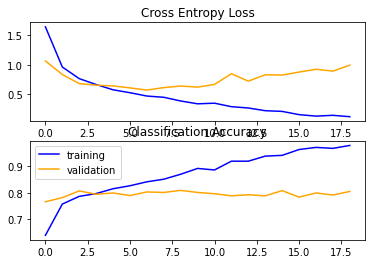

In [13]:
from matplotlib import pyplot as plt
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
 
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.legend(['training', 'validation'])
	plt.show()
 
summarize_diagnostics(history)

### Validation Confusion Matrix

32/32 [==============================] - 2s 68ms/step


<AxesSubplot:>

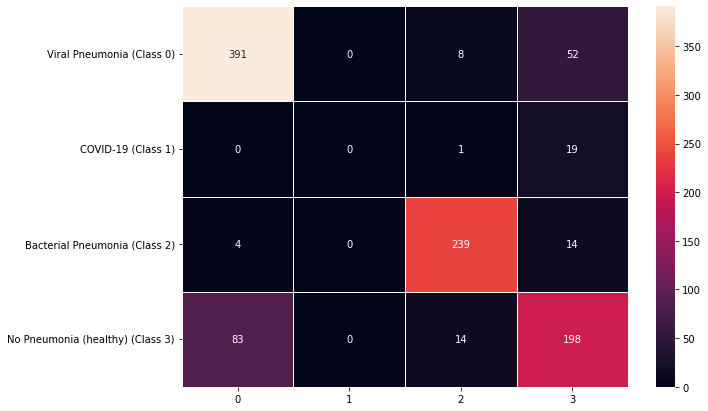

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_matrix = confusion_matrix(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))

labels = ['Viral Pneumonia (Class 0)','COVID-19 (Class 1)','Bacterial Pneumonia (Class 2)', 'No Pneumonia (healthy) (Class 3)']
cols = [0,1,2,3]
val_matrix = pd.DataFrame(val_matrix, index = labels,
                  columns = cols)

fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(val_matrix, annot=True,fmt='.0f', linewidths=.5, ax=ax)

### Test Confusion Matrix

40/40 [==============================] - 3s 67ms/step


<AxesSubplot:>

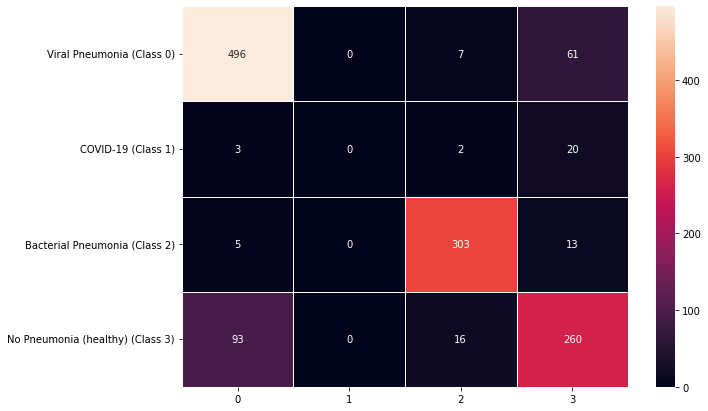

In [15]:
test_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1))

labels = ['Viral Pneumonia (Class 0)','COVID-19 (Class 1)','Bacterial Pneumonia (Class 2)', 'No Pneumonia (healthy) (Class 3)']
cols = [0,1,2,3]
test_matrix = pd.DataFrame(test_matrix, index = labels,
                  columns = cols)

fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(test_matrix, annot=True,fmt='.0f', linewidths=.5, ax=ax)

### Validation ROC

32/32 [==============================] - 2s 67ms/step
Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.94


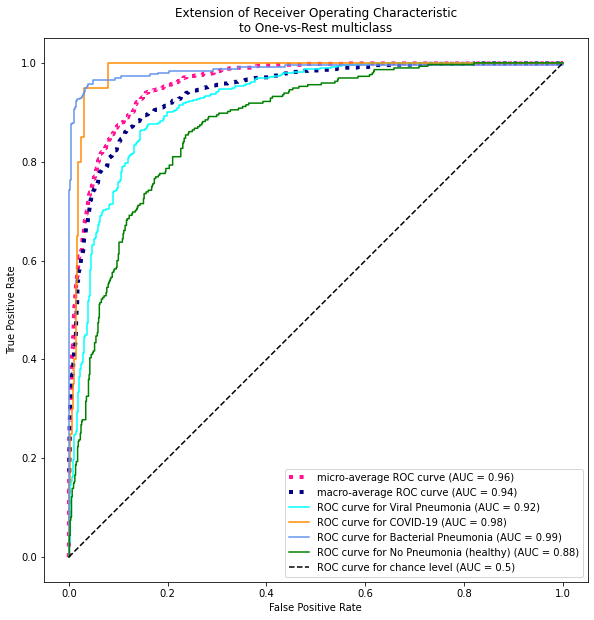

In [16]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

y_pred_val = model.predict(X_val)
n_classes = 4
target_names = ['Viral Pneumonia', 'COVID-19', 'Bacterial Pneumonia', 'No Pneumonia (healthy)']

################## micro
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

################## macro
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

################# ROC curves
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_val[:, class_id],
        y_pred_val[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

### Test ROC

40/40 [==============================] - 3s 67ms/step
Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.94


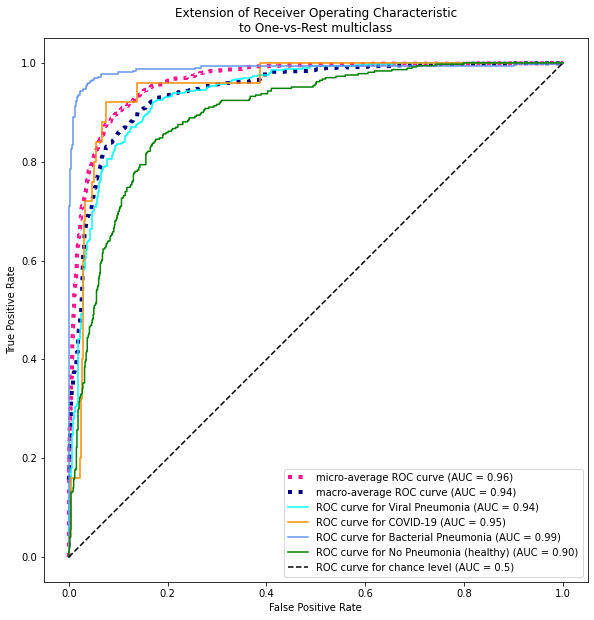

In [17]:
y_pred = model.predict(X_test)
n_classes = 4
target_names = ['Viral Pneumonia', 'COVID-19', 'Bacterial Pneumonia', 'No Pneumonia (healthy)']

################## micro
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

################## macro
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

################# ROC curves
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()